In [1]:
!pip install -q fasttext
!pip install -q sentence_transformers

In [2]:
import time
import pandas as pd
import numpy as np
import fasttext.util
import tensorflow as tf
from tqdm.auto import tqdm
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, pipeline

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/STS Measures/scopus_data/bart_summary.csv')
dataset.shape

(22427, 23)

<Axes: xlabel='Year'>

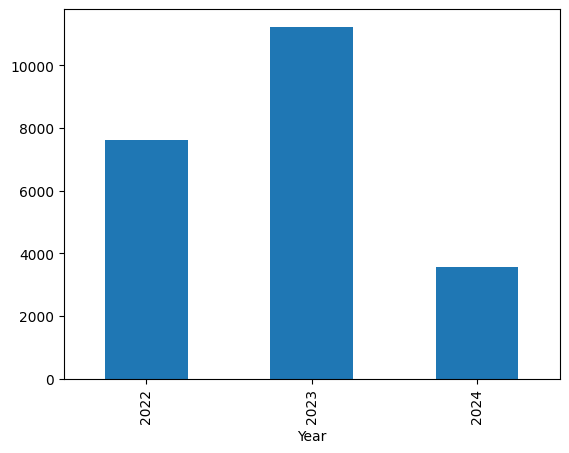

In [6]:
# Plot data distribution by year
dataset['Year'].value_counts().sort_index().plot(kind='bar')

In [7]:
years = [2022, 2023, 2024]
dataset = dataset[dataset['Year'].isin(years)]
dataset = dataset.sort_values(by='Year')
dataset.head()

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source,EID,Abstract Length in Words,Abstract Length in Characters,Summary
0,Kvasnica J.; Válková K.,"Kvasnica, Jakub (58021686400); Válková, Kateři...",58021686400; 56719748600,HOLISTIC ASSESSMENT METHODOLOGY FOR POSITIVE E...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,162,...,https://www.scopus.com/inward/record.uri?eid=2...,"Globally, cities are responsible for most of t...",assessment methods; Positive energy districts;...,NaN,Conference paper,Scopus,2-s2.0-85159934307,251,1674,The Positive Energy District (PED) concept has...
5091,Septriana F.E.; Soesilo T.E.B.; Sodri A.,"Septriana, Fentinur Evida (57236202800); Soesi...",57236202800; 57193915879; 56028045000,Sustainability Indicators for Biogas Productio...,2022,Lecture Notes in Civil Engineering,161,NaN,NaN,123,...,https://www.scopus.com/inward/record.uri?eid=2...,The sustainability assessment of the biogas pr...,Analytic hierarchy process; Biogas production;...,Biogas; Costs; Economics; Effluents; Energy ef...,Conference paper,Scopus,2-s2.0-85113763676,124,889,The sustainability assessment of the biogas pr...
5090,Martak Y.F.; Nurhasana R.,"Martak, Yusuf Faisal (57225954512); Nurhasana,...",57225954512; 57203681289,Having More Access Leads to Better Welfare: St...,2022,Lecture Notes in Civil Engineering,161,NaN,NaN,15,...,https://www.scopus.com/inward/record.uri?eid=2...,Disability groups are included in vulnerable g...,Disability; Disability Access; Impact; Spatial...,Health; Regression analysis; Sustainable devel...,Conference paper,Scopus,2-s2.0-85113780833,198,1222,Disability groups are included in vulnerable g...
5089,Tairas D.R.; Soenanto T.W.,"Tairas, David Ronald (57215000603); Soenanto, ...",57215000603; 57215004876,The Impact and Prevention of the Pandemic Cris...,2022,Lecture Notes in Civil Engineering,161,NaN,NaN,195,...,https://www.scopus.com/inward/record.uri?eid=2...,Indonesia for the first time confirmed the Cov...,Impact; Pandemic; Prevention; Sustainability,Engineering; Industrial engineering; Higher ed...,Conference paper,Scopus,2-s2.0-85113751938,114,742,Indonesia for the first time confirmed the Cov...
5088,Suresh R.; Murugaiyan V.,"Suresh, R. (57205367211); Murugaiyan, V. (2664...",57205367211; 26641414800,Influence of Microstructural and Geotechnical ...,2022,Lecture Notes in Civil Engineering,152,NaN,NaN,347,...,https://www.scopus.com/inward/record.uri?eid=2...,The present study is to elucidate the efficacy...,Calcium chloride; CEC; Expansive soil; Ultra-f...,Calcium chloride; Compressive strength; Plasti...,Conference paper,Scopus,2-s2.0-85114112790,179,1146,The present study is to elucidate the efficacy...


In [8]:
# dataset = dataset.reset_index(drop=True)
dataset.shape

(22427, 23)

In [9]:
# Find records where abstract is missing
missing_abstract = dataset[dataset['Abstract'].isnull()]
missing_abstract

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source,EID,Abstract Length in Words,Abstract Length in Characters,Summary


In [10]:
print('Word-wise:')
dataset['Summary Length in Words'] = dataset['Summary'].apply(lambda x: len(str(x).split()))
print(dataset['Summary Length in Words'].describe())

print('\nCharacter-wise:')
dataset['Summary Length in Characters'] = dataset['Summary'].apply(lambda x: len(str(x)))
print(dataset['Summary Length in Characters'].describe())

Word-wise:
count    22427.000000
mean        63.818745
std         19.701840
min          2.000000
25%         51.000000
50%         61.000000
75%         73.000000
max        228.000000
Name: Summary Length in Words, dtype: float64

Character-wise:
count    22427.000000
mean       438.531235
std        135.444554
min         12.000000
25%        347.000000
50%        416.000000
75%        505.000000
max       1621.000000
Name: Summary Length in Characters, dtype: float64


In [11]:
def cos_sim(v1, v2):
    mag1 = np.linalg.norm(v1)
    mag2 = np.linalg.norm(v2)
    if (not mag1) or (not mag2):
        return 0
    return np.dot(v1, v2) / (mag1 * mag2)

def calculate_similarity_scores(summary_embeddings, goal_embeddings):
    similarity_scores = cosine_similarity(summary_embeddings, goal_embeddings)
    return similarity_scores

In [12]:
# dataset = dataset[:1000]
abstracts = dataset['Summary'].tolist()

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def fits_in_token_limit(text, max_length=512):
    inputs = tokenizer(text, truncation=False, padding=False)
    return len(inputs['input_ids']) <= max_length

# Apply the function to filter the dataset
filtered_dataset = dataset[dataset['Summary'].apply(fits_in_token_limit)]

if filtered_dataset.shape[0] >= dataset.shape[0] * 0.9:
    dataset = filtered_dataset
    print(f"Filtered dataset has {dataset.shape[0]} records.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Filtered dataset has 22427 records.


In [14]:
filtered_dataset.shape

(22427, 25)

In [15]:
# pick 20 random records from the dataset
# random_indices = np.random.choice(dataset.shape[0], size=20, replace=False)
# dataset = dataset[:10]

In [16]:
texts = dataset['Abstract'].tolist()

In [17]:
goals_df = pd.read_csv('/content/drive/MyDrive/STS Measures/scopus_data/gpt_goals.csv')
goals = goals_df['Objective'].tolist()

In [18]:
def calculate_similarity_scores(embeddings):
    similarity_scores = cosine_similarity(embeddings)
    return similarity_scores

# Universal Sentence Encoder (USE)

In [7]:
# Load the USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [8]:
def get_use_query_embedding(query):
    return use_model([query]).numpy()

In [9]:
goal_embeddings = use_model(goals).numpy()

In [10]:
similarity_scores = calculate_similarity_scores(goal_embeddings)

In [11]:
for i in range(len(goals_df)):
    goals_df[f'Goal_{i+1}_Similarity'] = similarity_scores[i]

In [12]:
goals_df.to_csv('/content/drive/MyDrive/STS Measures/scores/use_goals.csv', index=False)

In [ ]:
# Process summaries in batches
batch_size = 100
n_batches = (len(abstracts) + batch_size - 1) // batch_size  # Ceiling division

similarity_scores_all = []

start_time = time.time()

for i in range(n_batches):
    batch_summaries = abstracts[i * batch_size:(i + 1) * batch_size]
    summary_embeddings = use_model(batch_summaries).numpy()
    batch_similarity_scores = calculate_similarity_scores(summary_embeddings, goal_embeddings)
    similarity_scores_all.extend(batch_similarity_scores)

print(f"Time taken for embedding and similarity calculation: {time.time() - start_time:.2f} seconds")

# Convert similarity scores to DataFrame
similarity_scores_df = pd.DataFrame(similarity_scores_all, columns=[f'Goal_{i+1}_Similarity' for i in range(len(goals))])

# Concatenate similarity scores with the original DataFrame
result_df = pd.concat([dataset, similarity_scores_df], axis=1)

Time taken for embedding and similarity calculation: 19.15 seconds


In [ ]:
result_df.to_csv('/content/drive/MyDrive/STS Measures/scopus_data/use_scores.csv', index=False)

# SentenceTransformers (BERT)



In [19]:
# Load the Sentence-BERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
def get_sbert_query_embedding(query):
    query_embedding = sbert_model.encode([query], convert_to_tensor=True, device=device)
    return query_embedding.cpu().numpy()

In [21]:
goal_embeddings = sbert_model.encode(goals, convert_to_tensor=True, device=device).cpu().numpy()

In [22]:
similarity_scores = calculate_similarity_scores(goal_embeddings)

# Add similarity scores to the original DataFrame
for i in range(len(goals_df)):
    goals_df[f'Goal_{i+1}_Similarity'] = similarity_scores[i]

# Save the updated DataFrame to a new CSV file
goals_df.to_csv('/content/drive/MyDrive/STS Measures/scores/stf_goals.csv', index=False)

In [ ]:
batch_size = 32
n_batches = (len(abstracts) + batch_size - 1) // batch_size  # Ceiling division

similarity_scores_all = []

start_time = time.time()

for i in range(n_batches):
    batch_summaries = abstracts[i * batch_size:(i + 1) * batch_size]
    summary_embeddings = sbert_model.encode(batch_summaries, convert_to_tensor=True, device=device).cpu().numpy()
    batch_similarity_scores = calculate_similarity_scores(summary_embeddings, goal_embeddings)
    similarity_scores_all.extend(batch_similarity_scores)

print(f"Time taken for embedding and similarity calculation: {time.time() - start_time:.2f} seconds")

# Convert similarity scores to DataFrame
similarity_scores_df = pd.DataFrame(similarity_scores_all, columns=[f'Goal_{i+1}_Similarity' for i in range(len(goals))])

# Concatenate similarity scores with the original DataFrame
result_df = pd.concat([dataset, similarity_scores_df], axis=1)

Time taken for embedding and similarity calculation: 1260.32 seconds


In [ ]:
result_df.to_csv('/content/drive/MyDrive/STS Measures/scores/stf_scores.csv', index=False)

# FastText

In [19]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
fasttext_model = fasttext.load_model('/content/drive/MyDrive/STS Measures/cc.en.300.bin')

In [20]:
def get_fasttext_embedding(text):
    words = text.split()
    word_vecs = [fasttext_model.get_word_vector(word) for word in words if word in fasttext_model]
    if word_vecs:
        return np.mean(word_vecs, axis=0)
    else:
        return np.zeros(300)

In [21]:
print("Generating FastText embeddings...")
goal_embeddings = np.array([get_fasttext_embedding(goal) for goal in goals])

Generating FastText embeddings...


In [22]:
similarity_scores = calculate_similarity_scores(goal_embeddings)

# Add similarity scores to the original DataFrame
for i in range(len(goals_df)):
    goals_df[f'Goal_{i+1}_Similarity'] = similarity_scores[i]

# Save the updated DataFrame to a new CSV file
goals_df.to_csv('/content/drive/MyDrive/STS Measures/scores/fasttext_goals.csv', index=False)

In [ ]:
batch_size = 100
n_batches = (len(abstracts) + batch_size - 1) // batch_size  # Ceiling division

similarity_scores_all = []

start_time = time.time()

for i in range(n_batches):
    batch_summaries = abstracts[i * batch_size:(i + 1) * batch_size]
    summary_embeddings = np.array([get_fasttext_embedding(summary) for summary in batch_summaries])
    batch_similarity_scores = calculate_similarity_scores(summary_embeddings, goal_embeddings)
    similarity_scores_all.extend(batch_similarity_scores)

print(f"Time taken for embedding and similarity calculation: {time.time() - start_time:.2f} seconds")

Time taken for embedding and similarity calculation: 4226.01 seconds


In [ ]:
similarity_scores_df = pd.DataFrame(similarity_scores_all, columns=[f'Goal_{i+1}_Similarity' for i in range(len(goals))])

# Concatenate similarity scores with the original DataFrame
result_df = pd.concat([dataset, similarity_scores_df], axis=1)

In [ ]:
result_df.to_csv('/content/drive/MyDrive/STS Measures/scores/fasttext_scores.csv', index=False)

# GloVe

In [19]:
# Load GloVe embeddings
def load_glove_model(glove_file):
    print("Loading GloVe Model")
    glove_model = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print("Done.", len(glove_model), " words loaded!")
    return glove_model

glove_model = load_glove_model('/content/drive/MyDrive/STS Measures/glove.6B.300d.txt')

Loading GloVe Model
Done. 400000  words loaded!


In [20]:
def get_glove_embedding(text, glove_model, embedding_dim=300):
    words = text.split()
    word_vecs = [glove_model[word] for word in words if word in glove_model]
    if word_vecs:
        return np.mean(word_vecs, axis=0)
    else:
        return np.zeros(embedding_dim)

In [21]:
goal_embeddings = np.array([get_glove_embedding(goal, glove_model) for goal in goals])

In [22]:
similarity_scores = calculate_similarity_scores(goal_embeddings)

# Add similarity scores to the original DataFrame
for i in range(len(goals_df)):
    goals_df[f'Goal_{i+1}_Similarity'] = similarity_scores[i]

# Save the updated DataFrame to a new CSV file
goals_df.to_csv('/content/drive/MyDrive/STS Measures/scores/glove_goals.csv', index=False)

In [ ]:
batch_size = 100
n_batches = (len(abstracts) + batch_size - 1) // batch_size  # Ceiling division

similarity_scores_all = []

start_time = time.time()

for i in range(n_batches):
    batch_summaries = abstracts[i * batch_size:(i + 1) * batch_size]
    summary_embeddings = np.array([get_glove_embedding(summary, glove_model) for summary in batch_summaries])
    batch_similarity_scores = calculate_similarity_scores(summary_embeddings, goal_embeddings)
    similarity_scores_all.extend(batch_similarity_scores)

print(f"Time taken for embedding and similarity calculation: {time.time() - start_time:.2f} seconds")

Time taken for embedding and similarity calculation: 3.78 seconds


In [ ]:
# Convert similarity scores to DataFrame
similarity_scores_df = pd.DataFrame(similarity_scores_all, columns=[f'Goal_{i+1}_Similarity' for i in range(len(goals))])

# Concatenate similarity scores with the original DataFrame
result_df = pd.concat([dataset, similarity_scores_df], axis=1)

In [ ]:
result_df.to_csv('/content/drive/MyDrive/STS Measures/scores/glove_scores.csv', index=False)

# ELMo

In [19]:
print("Loading ELMo model...")
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")

Loading ELMo model...


In [20]:
def get_elmo_embedding(texts):
    embeddings = elmo_model.signatures['default'](tf.constant(texts))['elmo']
    return tf.reduce_mean(embeddings, axis=1).numpy()

In [21]:
goal_embeddings = get_elmo_embedding(goals)

In [22]:
similarity_scores = calculate_similarity_scores(goal_embeddings)

# Add similarity scores to the original DataFrame
for i in range(len(goals_df)):
    goals_df[f'Goal_{i+1}_Similarity'] = similarity_scores[i]

# Save the updated DataFrame to a new CSV file
goals_df.to_csv('/content/drive/MyDrive/STS Measures/scores/elmo_goals.csv', index=False)

In [ ]:
batch_size = 100
n_batches = (len(abstracts) + batch_size - 1) // batch_size  # Ceiling division

similarity_scores_all = []

start_time = time.time()

for i in tqdm(range(n_batches), desc="Processing Summaries"):
    batch_summaries = abstracts[i * batch_size:(i + 1) * batch_size]
    summary_embeddings = get_elmo_embedding(batch_summaries)
    batch_similarity_scores = calculate_similarity_scores(summary_embeddings, goal_embeddings)
    similarity_scores_all.extend(batch_similarity_scores)

print(f"Time taken for embedding and similarity calculation: {time.time() - start_time:.2f} seconds")

Processing Summaries:   0%|          | 0/225 [00:00<?, ?it/s]

Time taken for embedding and similarity calculation: 836.50 seconds


In [ ]:
# Convert similarity scores to DataFrame
similarity_scores_df = pd.DataFrame(similarity_scores_all, columns=[f'Goal_{i+1}_Similarity' for i in range(len(goals))])

# Concatenate similarity scores with the original DataFrame
result_df = pd.concat([dataset, similarity_scores_df], axis=1)

In [ ]:
result_df.to_csv('/content/drive/MyDrive/STS Measures/scores/elmo_scores.csv', index=False)

# Testing Section



> Retrieving Scores



In [ ]:
score_paths = {
    'use': '/content/drive/MyDrive/STS Measures/scores/use_scores.csv',
    'stf': '/content/drive/MyDrive/STS Measures/scores/stf_scores.csv',
    'fasttext': '/content/drive/MyDrive/STS Measures/scores/fasttext_scores.csv',
    'glove': '/content/drive/MyDrive/STS Measures/scores/glove_scores.csv',
    'elmo': '/content/drive/MyDrive/STS Measures/scores/elmo_scores.csv',
}

In [ ]:
def print_top_3_goals(score_csv_path, indices):
    # Load the similarity scores CSV
    scores_df = pd.read_csv(score_csv_path, low_memory=False)

    # Function to get the top 5 goals for a given summary index and similarity scores DataFrame
    def get_top_3_goals(index, scores_df, goals_df):
        # Extract the similarity scores for the given index
        similarity_scores = scores_df.iloc[index, -17:]  # Assuming the last 17 columns are similarity scores for the 17 goals
        # Get the top 5 goals based on similarity scores
        top_3_indices = similarity_scores.argsort()[-3:][::-1]

        # Retrieve goal details
        top_3_goals = goals_df.iloc[top_3_indices]
        return top_3_goals

    # Print the top 5 goals for specified indices
    for index in indices:
        print(f"Summary for index {index}:")
        print(scores_df.loc[index, 'Summary'])
        print(f"\nTop 3 goals for summary index {index}:")
        top_3_goals = get_top_3_goals(index, scores_df, goals_df)
        for _, row in top_3_goals.iterrows():
            print(f"Goal Number: {row['Goal Number']}\nGoal Title: {row['Goal Title']}\nObjective: {row['Objective']}\n")
        print("\n")

In [ ]:
model = 'use'
score_csv_path = score_paths[model]
indices = [0, 1, 2]  # Replace with your specified indices
print_top_3_goals(score_csv_path, indices)

Summary for index 0:
The Positive Energy District (PED) concept has been pointed out as one of the key principles of this path. PEDs represent a relatively new and still not sufficiently explored area in the field of sustainable development. The early development phase is crucial since the structure of the urban area is being decided along with its sustainability and climate protection levels. The assessment methodology is based on the creation and optimization of energy balance scenarios. Case studies of existing urban areas have been developed in order to verify the methodology.

Top 3 goals for summary index 0:
Goal Number: 11
Goal Title: Sustainable Cities and Communities
Objective: The objective of Goal 11 is to make cities and human settlements inclusive, safe, resilient, and sustainable. Key areas of focus include improving urban planning, access to housing, and basic services. Enhancing resilience to disasters and reducing the environmental impact of cities are also important f

# Experimental Section

> Text Pre-processing



In [ ]:
exit(0)

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(stop_words, tokens):
    res = []
    for token in tokens:
        if not token in stop_words:
            res.append(token)
    return res

def process_text(text):
    text = text.encode('ascii', errors='ignore').decode()
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#+', ' ', text )
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    #text = re.sub(r"\'s", " ", text)     text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"isn't", "is not ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_list = []
    for token in tokens:
        lemma = lemmatizer.lemmatize(token, 'v')
        if lemma == token:
            lemma = lemmatizer.lemmatize(token)
        lemma_list.append(lemma)
    # return [ lemmatizer.lemmatize(token, 'v') for token in tokens ]     return lemma_list


def process_all(text):
    text = process_text(text)
    return ' '.join(remove_stopwords(stop_words, text.split()))